In [20]:
# 读取文件
import pandas as pd
data = pd.read_csv('./data.csv', encoding='utf-8')

由于下面在运行，所以我就直接讲解，下面是预处理，停用词是用的百度提供的通用停用词，你可以根据文本自己添加或者修改，主要是后面词云图和聚类展示环节，如果不要这个次的话，就直接添加在停用词表

In [21]:
import re

# 数据预处理，下面这个停用词文档可以自定义
stopwords_path = './stopwords_baidu.txt'

# 加载停用词
with open(stopwords_path, 'r', encoding='UTF-8') as file:
    stopwords = file.read().splitlines()


# 预处理函数，去除停用词
def remove_punctuation_and_stopwords(text):
    # 检查文本是否是字符串类型
    if isinstance(text, str):
        # 删除中文标点符号
        text = re.sub(r'[，。！？；：‘’“”（）【】《》、]', '', text)
        # 分词，这里简单以空格为分隔符（视具体情况而定，可能需要更复杂的分词方法）
        words = text.split()
        # 过滤停用词和语气词
        filtered_words = [word for word in words if word not in stopwords]
        return ' '.join(filtered_words)
    else:
        # 对于非字符串类型（如float/Nan等），可以选择返回原值或空字符串
        return ''


# 应用预处理函数到评论内容列
# 假设评论内容列名为 'comment'，请根据实际情况调整
data['comment_processed'] = data['评论内容'].apply(remove_punctuation_and_stopwords)
data.to_csv('./结果/预处理数据.csv', encoding='utf-8-sig')
# 查看预处理后的数据
print(data[['评论内容', 'comment_processed']].head())


                                评论内容          comment_processed
0            赶紧把这种人拉进高铁黑名单！本来抢票就够难的了     赶紧把这种人拉进高铁黑名单本来抢票就够难的了
1                    太嚣张了吧 这种人就该好好治治            太嚣张了吧 这种人就该好好治治
2                       无语了 就是仗着人多势众               无语了 就是仗着人多势众
3  这。。。高铁上的工作人员哪去了，十分钟。。。这不比高铁上化妆严重？  这高铁上的工作人员哪去了十分钟这不比高铁上化妆严重
4               三个人及以上可以定性为黑社会团伙性质了吧       三个人及以上可以定性为黑社会团伙性质了吧


选择k值

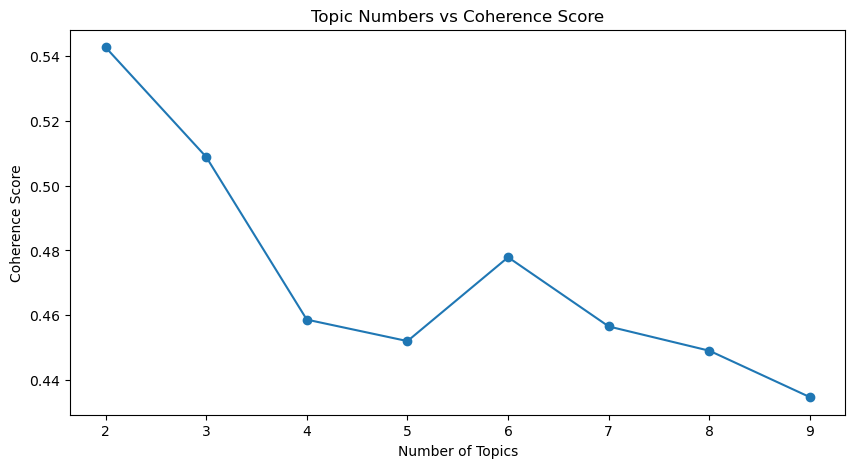

In [19]:
import pandas as pd
import jieba
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

texts = data['comment_processed']

# 分词处理
texts = [jieba.lcut(text) for text in texts]

# 构建词典
dictionary = corpora.Dictionary(texts)

# 构建语料库
corpus = [dictionary.doc2bow(text) for text in texts]

# 设置主题数量搜索范围
topic_nums = list(range(2, 10))

# 计算不同主题数的一致性值
coherence_values = []
for num_topics in topic_nums:
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(topic_nums, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Topic Numbers vs Coherence Score")
plt.xticks(topic_nums)
plt.show()


可以多次运行，确定k值，现在选择最优的7，因为运行时间比较久，上次运行后我打断了，最佳K为7，这种情况要多次运行，选择一个较好的，最大的值，两个主题显然不对，一般为6-10个主题比较合理，例如这个我就选择7个主题

bert-lda向量化表示，输出向量投入到自动编码器降维

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus, corpus2dense

# 假设 'data' 是一个 pandas DataFrame，且 'comment_processed' 是包含文本数据的列。
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['comment_processed'])

# 创建Gensim兼容的语料库
corpus = Sparse2Corpus(X, documents_columns=False)

# 从CountVectorizer词汇表创建一个Gensim字典
id2word = Dictionary()
id2word.token2id = vectorizer.vocabulary_
# 触发Gensim内部的id2token一致性检查
id2word.id2token = {id: token for token, id in vectorizer.vocabulary_.items()}

# 训练LDA模型
num_topics = 7  # 设置主题数
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)

# 获取每个文档的主题分布向量
num_docs = X.shape[0]
lda_topic_distributions = corpus2dense(lda_model[corpus], num_topics, num_docs).T

# 将原始文本和主题分布向量合并到一个新的DataFrame中
output_df = pd.DataFrame({
    '原文': data['comment_processed'],
    '主题分布向量': [' '.join(f"{prob:.3f}" for _, prob in lda_model.get_document_topics(bow, minimum_probability=0))
                     for bow in corpus]
})

# 输出向量化的主题分布数据
print(lda_topic_distributions)

# 保存向量化的主题分布数据到CSV文件
output_df.to_csv('./结果/lda_topic_distributions.csv', encoding='utf-8-sig')

# 展示表格前几行
print(output_df.head())


[[0.07143989 0.07143991 0.07143985 ... 0.07143991 0.5713607  0.07143988]
 [0.04763867 0.04763869 0.7136942  ... 0.04763869 0.04763869 0.04811243]
 [0.04764161 0.7141504  0.04764153 ... 0.04764163 0.04764163 0.0476416 ]
 ...
 [0.02380988 0.02380988 0.02380988 ... 0.02380988 0.02380988 0.8571407 ]
 [0.14297643 0.14350002 0.14087497 ... 0.14345579 0.14463662 0.14277743]
 [0.14285715 0.14285715 0.14285715 ... 0.14285715 0.14285715 0.14285715]]
                          原文                                     主题分布向量
0     赶紧把这种人拉进高铁黑名单本来抢票就够难的了  0.071 0.071 0.071 0.071 0.071 0.571 0.071
1            太嚣张了吧 这种人就该好好治治  0.048 0.048 0.714 0.048 0.048 0.048 0.048
2               无语了 就是仗着人多势众  0.048 0.714 0.048 0.048 0.048 0.048 0.048
3  这高铁上的工作人员哪去了十分钟这不比高铁上化妆严重  0.071 0.071 0.571 0.071 0.071 0.072 0.072
4       三个人及以上可以定性为黑社会团伙性质了吧  0.072 0.071 0.571 0.071 0.071 0.071 0.071


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 假设 lda_topic_distributions 是一个形状为 (文档数量, 主题数K) 的NumPy数组
# 转换为PyTorch tensor
X_tensor = torch.FloatTensor(lda_topic_distributions)

# 输入维度应该是主题数K
input_dim = lda_topic_distributions.shape[1]

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 编码维度，可以根据需要调整
encoding_dim = 32  # 或者任何适合您数据的维度
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器

dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# 训练自动编码器
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, targets = data
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 将编码后的输出存储下来，这些将用作聚类的输入
encoded_outputs = model.encoder(X_tensor).detach().numpy()

Epoch [1/50], Loss: 0.0894
Epoch [2/50], Loss: 0.0432
Epoch [3/50], Loss: 0.0191
Epoch [4/50], Loss: 0.0145
Epoch [5/50], Loss: 0.0145
Epoch [6/50], Loss: 0.0146
Epoch [7/50], Loss: 0.0138
Epoch [8/50], Loss: 0.0127
Epoch [9/50], Loss: 0.0135
Epoch [10/50], Loss: 0.0117
Epoch [11/50], Loss: 0.0107
Epoch [12/50], Loss: 0.0106
Epoch [13/50], Loss: 0.0080
Epoch [14/50], Loss: 0.0083
Epoch [15/50], Loss: 0.0064
Epoch [16/50], Loss: 0.0056
Epoch [17/50], Loss: 0.0042
Epoch [18/50], Loss: 0.0037
Epoch [19/50], Loss: 0.0025
Epoch [20/50], Loss: 0.0022
Epoch [21/50], Loss: 0.0018
Epoch [22/50], Loss: 0.0014
Epoch [23/50], Loss: 0.0013
Epoch [24/50], Loss: 0.0008
Epoch [25/50], Loss: 0.0009
Epoch [26/50], Loss: 0.0008
Epoch [27/50], Loss: 0.0006
Epoch [28/50], Loss: 0.0007
Epoch [29/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0005
Epoch [31/50], Loss: 0.0005
Epoch [32/50], Loss: 0.0004
Epoch [33/50], Loss: 0.0004
Epoch [34/50], Loss: 0.0004
Epoch [35/50], Loss: 0.0004
Epoch [36/50], Loss: 0.0004
E

对经过自动编码器处理的数据进行聚类，上面也包含改进聚类

In [24]:
from sklearn.cluster import KMeans

# 假设我们想要聚类成K个群
K = 6  # 你可以通过各种方法来确定K的最佳值，这个跟上面一样

# 执行K-means聚类
kmeans = KMeans(n_clusters=K, random_state=42,n_init=10)
kmeans.fit(encoded_outputs)

# 获取聚类标签
cluster_labels = kmeans.labels_

UMAP降维到二维空间，再可视化

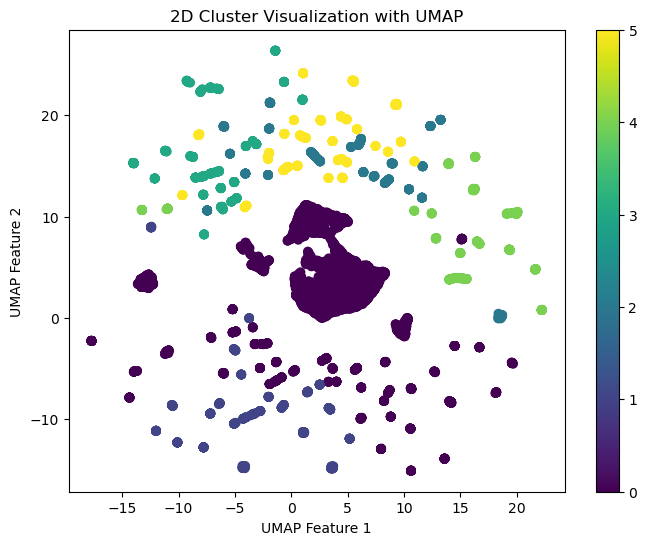

In [25]:
import umap.umap_ as umap

# 如果您不需要可复现的结果，并希望使用所有CPU核心，为了快速演示，我就使用所有核心
reducer = umap.UMAP(n_jobs=-1)  # 不设置random_state

# 如果您需要可复现的结果，并且接受只使用一个核心
# reducer = umap.UMAP(n_jobs=1, random_state=42)

encoded_outputs_2d = reducer.fit_transform(encoded_outputs)

# 可视化降维后的聚类结果
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(encoded_outputs_2d[:, 0], encoded_outputs_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.title('2D Cluster Visualization with UMAP')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.colorbar()
plt.show()

保存聚类结果

In [26]:
import pandas as pd
# 
data = pd.read_csv('./data.csv', encoding='utf-8')
import re

# 数据预处理，下面这个停用词文档可以自定义
stopwords_path = './stopwords_baidu.txt'

# 加载停用词
with open(stopwords_path, 'r', encoding='UTF-8') as file:
    stopwords = file.read().splitlines()


# 预处理函数，去除停用词
def remove_punctuation_and_stopwords(text):
    # 检查文本是否是字符串类型
    if isinstance(text, str):
        # 删除中文标点符号
        text = re.sub(r'[，。！？；：‘’“”（）【】《》、]', '', text)
        # 分词，这里简单以空格为分隔符（视具体情况而定，可能需要更复杂的分词方法）
        words = text.split()
        # 过滤停用词和语气词
        filtered_words = [word for word in words if word not in stopwords]
        return ' '.join(filtered_words)
    else:
        # 对于非字符串类型（如float/Nan等），可以选择返回原值或空字符串
        return ''
data['comment_processed'] = data['评论内容'].apply(remove_punctuation_and_stopwords)

data['cluster'] = cluster_labels  # 添加聚类标签作为新列

data.to_csv('./结果/聚类结果.csv')


针对每个类别词云图可视化

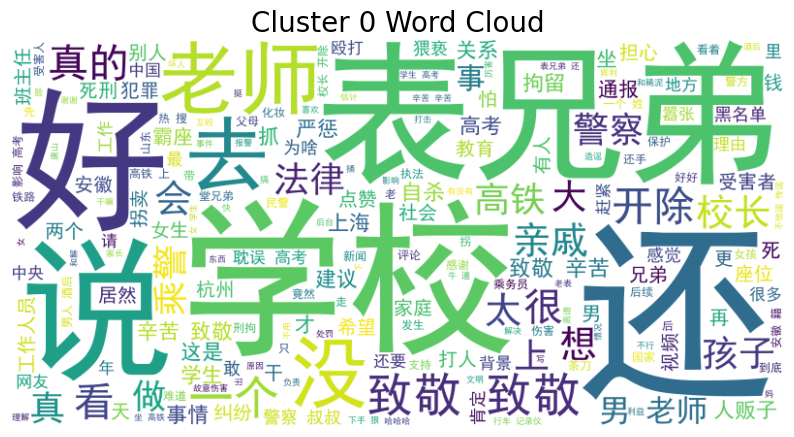

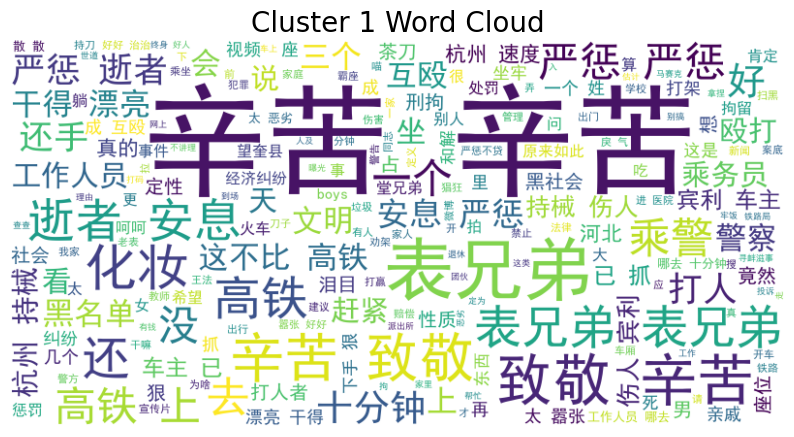

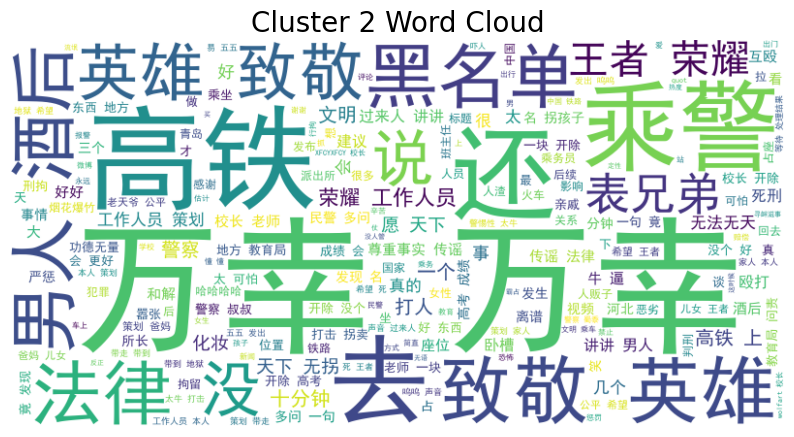

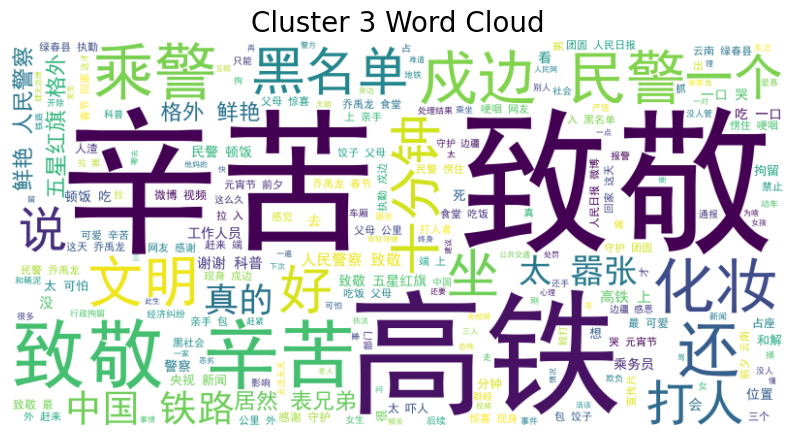

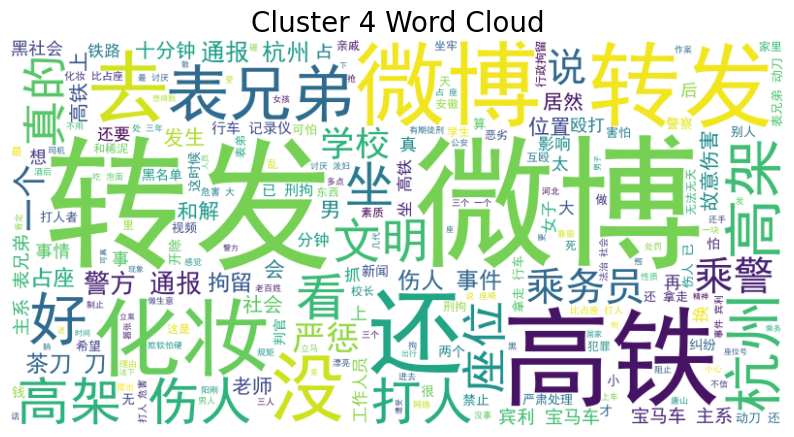

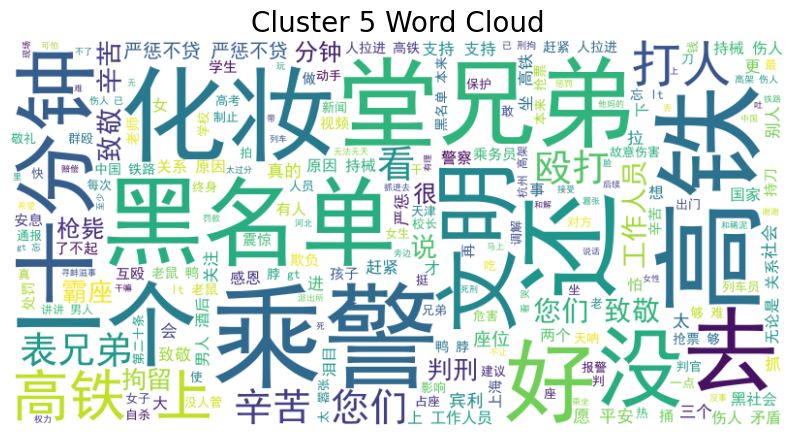

In [27]:
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 通用的中文字体路径（这里使用的是黑体，大多数Windows和macOS系统都自带这款字体）
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 对于Windows系统，可以尝试 'C:/Windows/Fonts/simhei.ttf'

# 为每个聚类生成词云图
for i in range(K):  # K 是聚类的数量
    plt.figure(figsize=(10, 7))
    # 先对每个评论进行分词，并移除停用词
    cluster_comments = data[data['cluster'] == i]['comment_processed']
    # 使用空格连接分词结果
    cluster_corpus = ' '.join([' '.join([word for word in jieba.cut(comment) if word not in stopwords])
                               for comment in cluster_comments])
    # 生成词云
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(cluster_corpus)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {i} Word Cloud', fontsize=20)
    plt.axis("off")
    plt.savefig(f'./结果/词云图/Cluster_{i}_Word_Cloud.png')
    plt.show()


In [28]:
from collections import Counter

keywords_df = pd.DataFrame()

# 为每个聚类提取关键词
for i in range(K):
    # 获取当前聚类的所有评论
    comments = data[data['cluster'] == i]['comment_processed']
    # 创建一个计数器来统计词频
    word_freq = Counter()
    # 分词并更新计数器
    for comment in comments:
        words = jieba.lcut(comment)
        words = [word for word in words if word not in stopwords and len(word) > 1]
        word_freq.update(words)
    # 提取当前聚类的前N个最常见词
    N = 5 #这个地方就可以根据你自己修改
    top_words = [word for word, freq in word_freq.most_common(N)]
    keywords_df[f'cluster{i}'] = top_words

# 显示或保存表格
print(keywords_df)
keywords_df.to_csv('./结果/cluster_keywords.csv', index=False, encoding='utf-8-sig')

  cluster0 cluster1 cluster2 cluster3 cluster4 cluster5
0       致敬       辛苦       万幸       致敬       转发       高铁
1      表兄弟      表兄弟       高铁       辛苦       微博       致敬
2       老师       高铁       法律       高铁       高铁       辛苦
3       学校       严惩       酒后       化妆      表兄弟       乘警
4       一个       致敬       警察      黑名单       化妆      黑名单


这就是主算法